# P2 Mask2Former Training and Validation Pipeline

Mask2Former model training and validation is included in this notebook.

The trained model will be used in ensemble which is implemented in Mask2Former+Unet.ipynb file.

In [1]:
%pip install -q git+https://github.com/huggingface/transformers.git
%pip install -q matplotlib rasterio numpy requests torch scipy albumentations

import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import random
from PIL import Image
import rasterio
import warnings
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

import torch
from torch import nn
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation, Mask2FormerConfig
from torch.utils.data import Dataset,DataLoader
from tqdm.auto import tqdm
from torch.optim import AdamW
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
import cv2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.8.0+cu128  Device: cuda


In [ ]:
# outlier clipping and finding mean, standard deviation for normalization

img_dir = "/root/workspace/val/VS_SN10_SN10"
BINS = 8192
LOW_Q, HIGH_Q = 0.001, 0.999

gmin = np.array([np.inf, np.inf, np.inf], dtype=np.float64)
gmax = np.array([-np.inf, -np.inf, -np.inf], dtype=np.float64)

tif_files = [f for f in sorted(os.listdir(img_dir)) if f.endswith(".tif")]
for fname in tif_files:
    fpath = os.path.join(img_dir, fname)
    with rasterio.open(fpath) as src:
        r = src.read(1).astype(np.float64)
        g = src.read(2).astype(np.float64)
        b = src.read(3).astype(np.float64)

    gmin = np.minimum(gmin, [r.min(), g.min(), b.min()])
    gmax = np.maximum(gmax, [r.max(), g.max(), b.max()])

print("[global min]", gmin)
print("[global max]", gmax)

eps = 1e-9
gmax = np.maximum(gmax, gmin + eps)

edges_r = np.linspace(gmin[0], gmax[0], BINS + 1)
edges_g = np.linspace(gmin[1], gmax[1], BINS + 1)
edges_b = np.linspace(gmin[2], gmax[2], BINS + 1)

hist_r = np.zeros(BINS, dtype=np.int64)
hist_g = np.zeros(BINS, dtype=np.int64)
hist_b = np.zeros(BINS, dtype=np.int64)

for fname in tif_files:
    fpath = os.path.join(img_dir, fname)
    with rasterio.open(fpath) as src:
        r = src.read(1).astype(np.float64).ravel()
        g = src.read(2).astype(np.float64).ravel()
        b = src.read(3).astype(np.float64).ravel()

    h_r, _ = np.histogram(r, bins=edges_r)
    h_g, _ = np.histogram(g, bins=edges_g)
    h_b, _ = np.histogram(b, bins=edges_b)
    hist_r += h_r; hist_g += h_g; hist_b += h_b

total_r = hist_r.sum()
total_g = hist_g.sum()
total_b = hist_b.sum()

def q_from_hist(hist, edges, q):
    c = np.cumsum(hist)
    thresh = q * c[-1]
    idx = np.searchsorted(c, thresh, side="left")
    idx = np.clip(idx, 0, len(edges) - 2)
    return edges[idx]

r_min = q_from_hist(hist_r, edges_r, LOW_Q)
r_max = q_from_hist(hist_r, edges_r, HIGH_Q)
g_min = q_from_hist(hist_g, edges_g, LOW_Q)
g_max = q_from_hist(hist_g, edges_g, HIGH_Q)
b_min = q_from_hist(hist_b, edges_b, LOW_Q)
b_max = q_from_hist(hist_b, edges_b, HIGH_Q)

print(f"Red: {r_min:.3f}, {r_max:.3f}")
print(f"Green: {g_min:.3f}, {g_max:.3f}")
print(f"Blue: {b_min:.3f}, {b_max:.3f}")


[global min] [0. 0. 0.]
[global max] [22864. 25456. 28816.]
Red: 1038.258, 6667.736
Green: 1096.920, 6441.686
Blue: 963.816, 6148.727


: 

In [ ]:
sum_r, sum_g, sum_b = 0.0, 0.0, 0.0
sqsum_r, sqsum_g, sqsum_b = 0.0, 0.0, 0.0
count_r, count_g, count_b = 0, 0, 0

tif_files = [f for f in sorted(os.listdir(img_dir)) if f.endswith(".tif")]
for fname in tif_files:
    fpath = os.path.join(img_dir, fname)
    with rasterio.open(fpath) as src:
        r = src.read(1).astype(np.float64).ravel()
        g = src.read(2).astype(np.float64).ravel()
        b = src.read(3).astype(np.float64).ravel()

    r_norm = np.clip((r - r_min) / (r_max - r_min), 0.0, 1.0)
    g_norm = np.clip((g - g_min) / (g_max - g_min), 0.0, 1.0)
    b_norm = np.clip((b - b_min) / (b_max - b_min), 0.0, 1.0)

    sum_r += r_norm.sum(); sqsum_r += (r_norm ** 2).sum(); count_r += r_norm.size
    sum_g += g_norm.sum(); sqsum_g += (g_norm ** 2).sum(); count_g += g_norm.size
    sum_b += b_norm.sum(); sqsum_b += (b_norm ** 2).sum(); count_b += b_norm.size

mean_r = sum_r / count_r
mean_g = sum_g / count_g
mean_b = sum_b / count_b

std_r = np.sqrt(sqsum_r / count_r - mean_r**2)
std_g = np.sqrt(sqsum_g / count_g - mean_g**2)
std_b = np.sqrt(sqsum_b / count_b - mean_b**2)

print(f"Red   mean={mean_r:.6f}, std={std_r:.6f}")
print(f"Green mean={mean_g:.6f}, std={std_g:.6f}")
print(f"Blue  mean={mean_b:.6f}, std={std_b:.6f}")

In [3]:
# r_min = 1121.969
# r_max = 4942.150
# g_min = 1207.664
# g_max = 4702.109
# b_min = 1053.633
# b_max = 4507.207

r_min = 1045.748
r_max = 6740.959
g_min = 1102.797
g_max = 6511.914
b_min = 959.977
b_max = 6216.434

mean_r = 0.186763
mean_g = 0.174535
mean_b = 0.164897
std_r  = 0.120966
std_g  = 0.103745
std_b  = 0.107954

In [4]:
processor = AutoImageProcessor.from_pretrained(
    "facebook/mask2former-swin-large-cityscapes-semantic", 
    do_rescale = False,
    do_normalize = True,
    image_mean = [mean_r, mean_g, mean_b],
    image_std = [std_r, std_g, std_b]
)
id2label = {0: "background", 1: "target"}
label2id = {v: k for k, v in id2label.items()}
config = Mask2FormerConfig.from_pretrained(
    "facebook/mask2former-swin-large-cityscapes-semantic",
    id2label=id2label, label2id=label2id, num_labels=len(id2label)
)
config.backbone_config.drop_rate = 0.1
config.backbone_config.attn_drop_rate = 0.1
config.backbone_config.drop_path_rate = 0.1
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-large-cityscapes-semantic",
    config=config,
    ignore_mismatched_sizes=True
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/venv/main/lib/python3.12/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_predictor.weight: found shape torch.Size([20, 256]) in the ch

In [ ]:
# augmentation

def to_float32(img, **kwargs):
    return img.astype(np.float32, copy=False)

def keep_mask_int(msk, **kwargs):
    if msk.dtype != np.int64:
        msk = msk.astype(np.int64, copy=False)
    return msk

def clip01(img, **kwargs):
    return np.clip(img, 0.0, 1.0)

H, W = 512, 512

transform = A.Compose([
    A.Lambda(image=to_float32, mask=keep_mask_int),

    
    # A.OneOf([
    #     A.RandomResizedCrop(size=(H, W), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    #     A.Resize(H, W)
    # ], p=1.0),

    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=1.0),
    
    A.OneOf([
        A.GaussNoise(std_range=(0.0, 0.005), mean=0.0, p=1.0),
        A.MultiplicativeNoise(multiplier=(0.95, 1.05), per_channel=True, p=1.0),
    ], p=0.3),
    # A.OneOf([
    #     A.GaussianBlur(blur_limit=(2, 3), p=1.0),
    #     A.MotionBlur(blur_limit=3, p=1.0),
    # ], p=0.3),
    
    # A.OneOf([
    #     A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1.0),
    #     A.RandomGamma(gamma_limit=(80, 120), p=1.0),
    #     A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    # ], p=0.5),
    
    A.Lambda(image=clip01),
])


def augmentation(image, mask):
    # image: (H,W,3), float32, range (0,1)
    # mask : (H,W), int, 0/1
    out = transform(image=image, mask=mask)
    img_aug, msk_aug = out["image"], out["mask"]
    return img_aug, msk_aug

/tmp/ipykernel_46206/1496344693.py:28: UserWarning: Argument(s) 'mean' are not valid for transform GaussNoise
  A.GaussNoise(std_range=(0.0, 0.005), mean=0.0, p=1.0),


In [6]:
##label은 10/90으로 구성된다... 10이 검은색 /  90이 노란색

class SatelliteImageDataset(Dataset):
  def __init__(self, img_dir, label_dir, transform=None):
    self.img_dir   = img_dir
    self.label_dir = label_dir
    self.transform = transform

    self.img_files   = sorted([f for f in os.listdir(img_dir) if f.endswith('.tif')])
    self.label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.tif')])
    assert len(self.img_files) == len(self.label_files), "data number mismatch"

  def __len__(self):
    return len(self.img_files)

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_files[idx])
    label_path = os.path.join(self.label_dir, self.label_files[idx])

    with rasterio.open(img_path) as src:
      red   = src.read(1).astype(np.float32)
      green = src.read(2).astype(np.float32)
      blue  = src.read(3).astype(np.float32)

      red   = (red   - r_min) / (r_max - r_min)
      green = (green - g_min) / (g_max - g_min)
      blue  = (blue  - b_min) / (b_max - b_min)

      image = np.dstack((red, green, blue))
      image = image.clip(0, 1)

    with rasterio.open(label_path) as src:
      label = src.read(1)
      label = (label==10).astype(np.int64)

    if self.transform:
      image, label = self.transform(image, label)

    image = torch.from_numpy(image).float().permute(2,0,1)  #(H,W,C) => (C,H,W)
    label = torch.from_numpy(label).long()
    return image, label

In [7]:
def collate_fn(batch):
    imgs  = [img.permute(1,2,0).numpy() for (img, msk) in batch]     # CHW -> HWC float32[0,1]
    masks = [msk.numpy().astype(np.int64) for (img, msk) in batch]   # HW int64

    enc = processor(
        images=imgs,
        segmentation_maps=masks,
        return_tensors="pt",
        size={"height": 512, "width": 512},
        do_rescale=False,
    )
    return enc   # keys: pixel_values, mask_labels(list), class_labels(list)

In [8]:
#hyperparameter set
batch_size = 7
lr = 0.0001
num_epochs = 30

In [9]:
train_data   = SatelliteImageDataset(img_dir='/root/workspace/train/TS_SN10_SN10',label_dir='/root/workspace/train/TL_SN10',transform=augmentation)
val_data     = SatelliteImageDataset(img_dir='/root/workspace/val/VS_SN10_SN10',label_dir='/root/workspace/val/VL_SN10',transform=None)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, collate_fn=collate_fn)

In [10]:
NUM_CLASSES = model.config.num_labels # 2

@torch.no_grad()
def pred_from_outputs(outputs, H, W, num_classes):
    # outputs.class_queries_logits: (B,Q,C+1), outputs.masks_queries_logits: (B,Q,h',w')
    class_logits = outputs.class_queries_logits
    mask_logits  = outputs.masks_queries_logits
    class_scores = class_logits.softmax(-1)[..., :num_classes]    # drop no-object
    mask_probs   = mask_logits.sigmoid()
    # (B,Q,C) x (B,Q,h',w') -> (B,C,h',w')
    sem_lowres   = torch.einsum('bqc,bqhw->bchw', class_scores, mask_probs)
    sem          = torch.nn.functional.interpolate(sem_lowres, size=(H, W), mode='bilinear', align_corners=False)
    pred         = sem.argmax(1)                          # (B,H,W), GPU
    return pred

@torch.no_grad()
def sem_probs_from_outputs(outputs, H, W, num_classes):
    class_scores = outputs.class_queries_logits.softmax(-1)[..., :num_classes]  # (B,Q,C)
    mask_probs   = outputs.masks_queries_logits.sigmoid()                       # (B,Q,h',w')
    sem_lowres   = torch.einsum('bqc,bqhw->bchw', class_scores, mask_probs)     # (B,C,h',w')
    sem          = F.interpolate(sem_lowres, size=(H, W), mode='bilinear', align_corners=False)
    return sem  # (B,C,H,W), 확률 해석(0~1)

@torch.no_grad()
def m2f_sem_probs_from_outputs(m2f_outputs, H, W, num_classes=2):
    class_scores = m2f_outputs.class_queries_logits.softmax(-1)[..., :num_classes]  # (B,Q,C)
    mask_probs   = m2f_outputs.masks_queries_logits.sigmoid()                       # (B,Q,h',w')
    sem_lowres   = torch.einsum('bqc,bqhw->bchw', class_scores, mask_probs)         # (B,C,h',w')
    sem          = F.interpolate(sem_lowres, size=(H, W), mode='bilinear', align_corners=False)
    return sem.clamp(0.0, 1.0)  # (B,C,H,W)

@torch.no_grad()
def m2f_tta_probs(model, pixel_values, num_classes):
    B, C, H, W = pixel_values.shape
    probs_acc, nviews = None, 0

    def fwd(x, undo):
        nonlocal probs_acc, nviews
        x = x.contiguous()
        output = model(pixel_values=x)
        prob = m2f_sem_probs_from_outputs(output, H, W, num_classes)  # (B,C,out_H,out_W)
        prob = undo(prob)
        probs_acc = prob if probs_acc is None else probs_acc + prob
        nviews += 1

    x = pixel_values
    out_H, out_W = H, W
    fwd(x, undo=lambda t: t) # identity
    fwd(x.flip(-1), undo=lambda t: t.flip(-1)) # hflip
    fwd(x.flip(-2), undo=lambda t: t.flip(-2)) # vflip
    fwd(x.transpose(-1, -2), undo=lambda t: t.transpose(-1, -2)) # transpose

    probs_mean = probs_acc / float(nviews)          # (B,C,H,W)
    return probs_mean


def build_targets(mask_labels_list, class_labels_list, H, W, device):
    tgts = []
    for masks, classes in zip(mask_labels_list, class_labels_list):
        tgt = torch.zeros((H, W), dtype=torch.long, device=device)
        if masks.ndim == 3:
            for m, c in zip(masks, classes):
                tgt[m.bool()] = int(c.item())
        tgts.append(tgt)
    return tgts

@torch.no_grad()
def accumulate_iou(pred, tgt, num_classes):
    inter = torch.zeros(num_classes, dtype=torch.float64, device=pred.device)
    union = torch.zeros(num_classes, dtype=torch.float64, device=pred.device)
    for c in range(num_classes):
        p = (pred == c); t = (tgt == c)
        inter[c] += (p & t).sum().double()
        union[c] += (p | t).sum().double()
    return inter, union

def miou_from_inter_union(inter, union):
    iou = inter / (union + 1e-10)
    valid = union > 0
    return (iou[valid].mean().item() if valid.any() else float("nan"))


In [ ]:
# training and validation

miou_every = 10
start_epoch = 0

model.to(DEVICE)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
scheduler=CosineAnnealingLR(optimizer, T_max=30, eta_min=lr/10)

checkpoint_path = '/root/workspace/models/Mask2Former_model.pth'

if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path, weights_only=False)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  scheduler.load_state_dict(checkpoint['scheduler'])
  start_epoch = checkpoint['epoch'] + 1
  train_losses = checkpoint.get('train_losses', [])
  val_losses = checkpoint.get('val_losses', [])
  train_mIoUs = checkpoint.get('train_mIoU', [])
  val_mIoUs = checkpoint.get('val_mIoU', [])
  print(f"Resuming training from epoch {start_epoch}")
else:
  train_losses = []
  val_losses = []
  train_mIoUs = []
  val_mIoUs = []

for epoch in range(start_epoch):
  print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_losses[epoch]:.4f} | Train mIoU: {train_mIoUs[epoch]:.4f} | Val Loss: {val_losses[epoch]:.4f} | Val mIoU: {val_mIoUs[epoch]:.4f}")

for epoch in range(start_epoch,num_epochs):
    # ---------- Train ----------
    model.train()
    train_running = 0.0
    train_inter = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=DEVICE)
    train_union = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=DEVICE)
    train_bar = tqdm(train_loader, desc=f"Train {epoch+1}/{num_epochs}", leave=False)

    for step, batch in enumerate(train_bar, 1):
        pixel_values = batch["pixel_values"].to(DEVICE)
        mask_labels  = [x.to(DEVICE) for x in batch["mask_labels"]]
        class_labels = [x.to(DEVICE) for x in batch["class_labels"]]

        outputs = model(pixel_values=pixel_values,
                        mask_labels=mask_labels,
                        class_labels=class_labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running += loss.item()

        # ---- mIoU ----
        if step % miou_every == 0:
          H, W = pixel_values.shape[-2], pixel_values.shape[-1]
          B = pixel_values.size(0)
          with torch.no_grad():
              # prob = m2f_sem_probs_from_outputs(outputs, H, W, NUM_CLASSES)
              # pred = (prob[:, 1] >= 0.5).long()
              pred = processor.post_process_semantic_segmentation(
                  outputs, target_sizes=[(H, W)] * B
              )
              tgts = build_targets(mask_labels, class_labels, H, W, device=pixel_values.device)
              for p, t in zip(pred, tgts):
                  p = p.to(t.device)
                  inter, uni = accumulate_iou(p, t, NUM_CLASSES)
                  train_inter += inter; train_union += uni
              del pred, tgts
          train_mIoU = miou_from_inter_union(train_inter, train_union)
          train_bar.set_postfix(loss=f"{train_running/step:.4f}", mIoU=f"{train_mIoU:.4f}")
        else:
            train_bar.set_postfix(loss=f"{train_running/step:.4f}")

    train_epoch_loss = train_running / len(train_loader)
    train_losses.append(train_epoch_loss)
    train_mIoU = miou_from_inter_union(train_inter, train_union)
    train_mIoUs.append(train_mIoU)

    scheduler.step()


    # ---------- Validation ----------
    model.eval()
    val_epoch_loss = float("inf")
    val_mIoU = float("nan")
    if val_loader is not None:
        val_running = 0.0
        val_inter = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=DEVICE)
        val_union = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=DEVICE)
        val_bar = tqdm(val_loader, desc=f"Val   {epoch+1}/{num_epochs}", leave=False)
        with torch.no_grad():
            for step, batch in enumerate(val_bar, 1):
                pv = batch["pixel_values"].to(DEVICE)
                ml = [x.to(DEVICE) for x in batch["mask_labels"]]
                cl = [x.to(DEVICE) for x in batch["class_labels"]]

                outputs = model(pixel_values=pv, mask_labels=ml, class_labels=cl)
                val_running += outputs.loss.item()

                H, W = pv.shape[-2], pv.shape[-1]
                B = pv.size(0)
                # prob = m2f_sem_probs_from_outputs(outputs, H, W, NUM_CLASSES)
                # pred = (prob[:, 1] >= 0.5).long()
                pred = processor.post_process_semantic_segmentation(
                    outputs, target_sizes=[(H, W)] * B
                )
                tgts = build_targets(ml, cl, H, W, device=pv.device)
                for p, t in zip(pred, tgts):
                    p = p.to(t.device)
                    inter, uni = accumulate_iou(p, t, NUM_CLASSES)
                    val_inter += inter; val_union += uni
                del pred, tgts
                cur_miou = miou_from_inter_union(val_inter, val_union)
                val_bar.set_postfix(loss=f"{val_running/step:.4f}", mIoU=f"{cur_miou:.4f}")

        val_epoch_loss = val_running / len(val_loader)
        val_losses.append(val_epoch_loss)
        val_mIoU = miou_from_inter_union(val_inter, val_union)
        val_mIoUs.append(val_mIoU)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"train_loss={train_epoch_loss:.4f} | train_mIoU={train_mIoU:.4f} | "
          f"val_loss={val_epoch_loss:.4f} | val_mIoU={val_mIoU:.4f}")
    torch.save({'model':model.state_dict(),'optimizer':optimizer.state_dict(),'scheduler':scheduler.state_dict(),
                'epoch':epoch,'train_losses': train_losses,'val_losses': val_losses,
                'train_mIoU':train_mIoUs,'val_mIoU':val_mIoUs}, checkpoint_path)

Resuming training from epoch 27
Epoch [1/30] | Train Loss: 23.3090 | Train mIoU: 0.8743 | Val Loss: 19.4857 | Val mIoU: 0.9027
Epoch [2/30] | Train Loss: 15.3752 | Train mIoU: 0.9187 | Val Loss: 14.2337 | Val mIoU: 0.9280
Epoch [3/30] | Train Loss: 12.6101 | Train mIoU: 0.9340 | Val Loss: 12.9246 | Val mIoU: 0.9348
Epoch [4/30] | Train Loss: 10.4702 | Train mIoU: 0.9450 | Val Loss: 11.7054 | Val mIoU: 0.9433
Epoch [5/30] | Train Loss: 9.0649 | Train mIoU: 0.9557 | Val Loss: 10.0107 | Val mIoU: 0.9509
Epoch [6/30] | Train Loss: 9.2091 | Train mIoU: 0.9545 | Val Loss: 9.5273 | Val mIoU: 0.9532
Epoch [7/30] | Train Loss: 7.0869 | Train mIoU: 0.9655 | Val Loss: 8.7524 | Val mIoU: 0.9573
Epoch [8/30] | Train Loss: 7.0443 | Train mIoU: 0.9666 | Val Loss: 8.9151 | Val mIoU: 0.9570
Epoch [9/30] | Train Loss: 6.2452 | Train mIoU: 0.9699 | Val Loss: 7.6920 | Val mIoU: 0.9632
Epoch [10/30] | Train Loss: 5.6481 | Train mIoU: 0.9723 | Val Loss: 7.7814 | Val mIoU: 0.9634
Epoch [11/30] | Train Loss: 

Train 28/30:   0%|          | 0/1143 [00:00<?, ?it/s]

Val   28/30:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch [28/30] | train_loss=2.8265 | train_mIoU=0.9904 | val_loss=5.7359 | val_mIoU=0.9787


Train 29/30:   0%|          | 0/1143 [00:00<?, ?it/s]

Val   29/30:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch [29/30] | train_loss=2.7922 | train_mIoU=0.9901 | val_loss=5.7731 | val_mIoU=0.9789


Train 30/30:   0%|          | 0/1143 [00:00<?, ?it/s]

Val   30/30:   0%|          | 0/143 [00:00<?, ?it/s]

Epoch [30/30] | train_loss=2.7939 | train_mIoU=0.9904 | val_loss=5.8369 | val_mIoU=0.9789


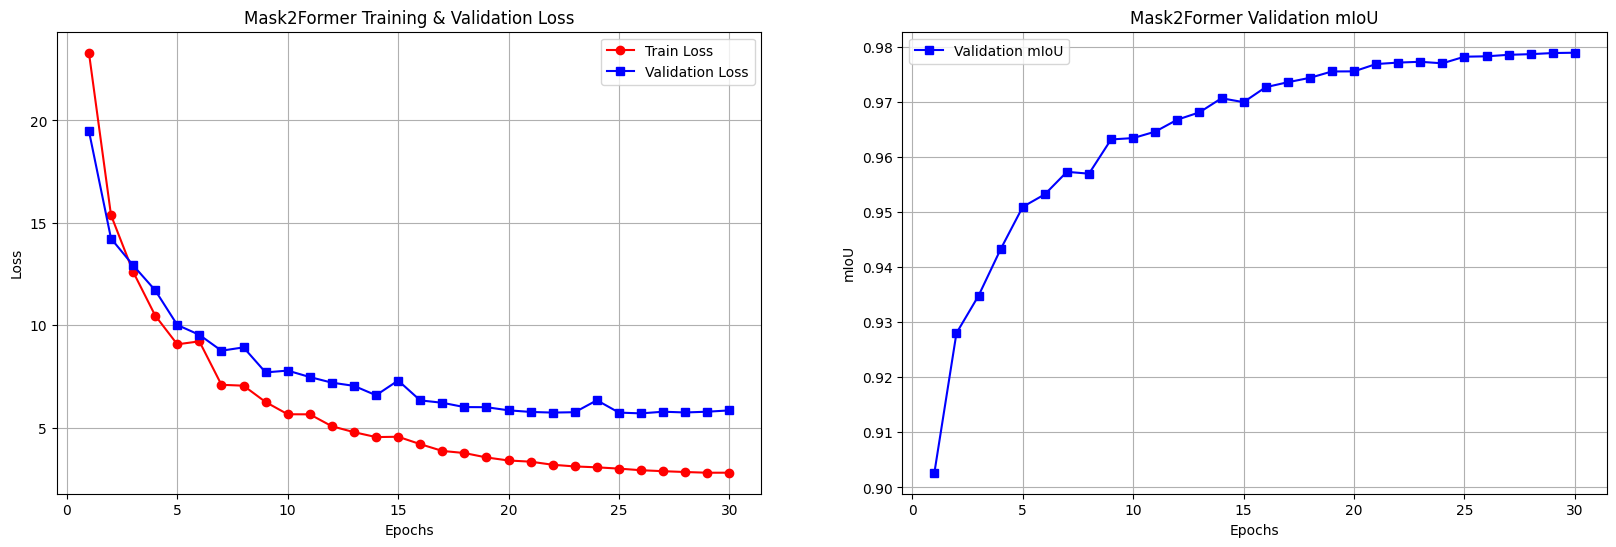

: 

In [ ]:
# visualization of loss and mIoU

import matplotlib.pyplot as plt
import os
import torch
checkpoint_path = '/root/workspace/models/Mask2Former_model.pth'

if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path, weights_only=False)
  train_losses = checkpoint.get('train_losses', [])
  val_losses = checkpoint.get('val_losses', [])
  train_mIoUs = checkpoint.get('train_mIoU', [])
  val_mIoUs = checkpoint.get('val_mIoU', [])
  
fig, ax = plt.subplots(1, 2, figsize=(20,6))

epochs = range(1, 30 + 1)
ax[0].plot(epochs, train_losses, 'r-o', label='Train Loss')
ax[0].plot(epochs, val_losses, 'b-s', label='Validation Loss')

# ax[1].plot(epochs, train_mIoUs, 'r-o', label='Train mIoU')
ax[1].plot(epochs, val_mIoUs, 'b-s', label='Validation mIoU')

ax[0].set_title('Mask2Former Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].set_title('Mask2Former Validation mIoU')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('mIoU')


ax[0].legend()
ax[0].grid(True)

ax[1].legend()
ax[1].grid(True)

plt.show()

In [ ]:
file_name = '/root/workspace/train/TS_SN10_SN10/SN10_CHN_00003_230409.tif'
label_name = '/root/workspace/train/TL_SN10/SN10_CHN_00003_230409.tif'
with rasterio.open(file_name) as src:
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)
    red   = (red   - r_min)   / (r_max   - r_min)
    green = (green - g_min) / (g_max - g_min)
    blue  = (blue  - b_min)  / (b_max  - b_min)
    img = np.dstack((red, green, blue))
    img = img.clip(0, 1)
with rasterio.open(label_name) as src:
    label = src.read(1)
    label = (label==90).astype(np.int64)
# img, label = augmentation(img, label)
inputs = processor(images=img, return_tensors="pt", do_rescale=False)
fig, ax = plt.subplots(1, 2, figsize=(20,6))

ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(img)
ax[1].imshow(label)

In [ ]:
# simple visualization (not necessary)

@torch.no_grad()
def pred_from_outputs(outputs, H, W, num_classes):
    # outputs.class_queries_logits: (B,Q,C+1), outputs.masks_queries_logits: (B,Q,h',w')
    class_logits = outputs.class_queries_logits
    mask_logits  = outputs.masks_queries_logits
    class_scores = class_logits.softmax(-1)[..., :num_classes]    # drop no-object
    mask_probs   = mask_logits.sigmoid()
    # (B,Q,C) x (B,Q,h',w') -> (B,C,h',w')
    sem_lowres   = torch.einsum('bqc,bqhw->bchw', class_scores, mask_probs)
    sem          = torch.nn.functional.interpolate(sem_lowres, size=(H, W), mode='bilinear', align_corners=False)
    pred         = sem.argmax(1)                          # (B,H,W), GPU
    return pred

H, W = img.shape[:2]
model.eval()
with torch.no_grad():
    enc = processor(images=[img], return_tensors="pt", do_rescale=False, size={"height": 512, "width": 512})

    
pixel_values = enc["pixel_values"].to(DEVICE) # (1,3,H,W)
prob = m2f_tta_probs(
    model, pixel_values, NUM_CLASSES
)
pred = prob[:, 1] >= 0.5
pred = pred.detach().cpu().numpy().astype(np.uint8)

palette_vals = np.array([10, 90], dtype=np.uint8)
color_seg = palette_vals[pred]          # (H,W), 10/90 단채널

with rasterio.open(label_name) as src:
    img_label = src.read(1).astype(np.uint16)  # {10,90}

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

seg_idx = (color_seg == 10).transpose(1, 2, 0).astype(np.uint8)
gt_idx  = (img_label == 90).astype(np.uint8)

cmap = ListedColormap([[0,0,0], [1,1,0]])
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(seg_idx, cmap=cmap, norm=norm); ax[0].set_title("Prediction (matched path)"); ax[0].axis('off')
ax[1].imshow(gt_idx,  cmap=cmap, norm=norm); ax[1].set_title("Ground Truth"); ax[1].axis('off')
plt.show()


In [ ]:
# simple visualization (not necessary)

# H, W = img.shape[:2]

# with torch.no_grad():
#     enc = processor(images=[img], return_tensors="pt", do_rescale=False)
#     enc = {k: v.to(DEVICE) for k, v in enc.items()}
#     outputs = model(**enc)

# predicted_map = processor.post_process_semantic_segmentation(
#     outputs, target_sizes=[(H, W)]
# )[0]
# if isinstance(predicted_map, torch.Tensor):
#     predicted_map = predicted_map.detach().cpu().numpy().astype(np.uint8)
# seg = predicted_map  # (H,W) np.uint8
# color_palette = [10, 90]
# palette = np.asarray(color_palette, dtype=np.uint8)

# color_seg = np.zeros((H, W, 1), dtype=np.uint8)
# for label, color in enumerate(palette):
#     color_seg[seg == label] = color

# # GT
# with rasterio.open(label_name) as src:
#     img_label = src.read(1).astype(np.float32)
# img_label = img_label / img_label.max()

# fig, ax = plt.subplots(1, 2, figsize=(16,8))
# ax[0].imshow(color_seg);       ax[0].axis('off')
# ax[1].imshow(img_label); ax[1].axis('off')
# plt.show()

In [ ]:

# import numpy as np, torch, rasterio, matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap, BoundaryNorm

# # 0=검정, 1=노랑
# cmap = ListedColormap([[0,0,0], [1,1,0]])
# norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

# # --- 1) 예측 (이미 구한 predicted_map 사용 가정: (H,W) 정수 레이블) ---
# if isinstance(predicted_map, torch.Tensor):
#     pred_idx = predicted_map.detach().cpu().numpy().astype(np.int64)
# else:
#     pred_idx = np.asarray(predicted_map).astype(np.int64)

# # 모델이 2클래스인지 점검
# uniq_pred = np.unique(pred_idx)
# print("[pred unique]", uniq_pred)

# # 필요시: 예측이 0/1 외의 값을 갖는다면 2클래스 작업에 맞게 클램프
# pred_idx = np.clip(pred_idx, 0, 1).astype(np.uint8)

# # --- 2) GT 10/90 -> 0/1 매핑 (flip_gt=True로 바꿔서 반전 테스트 가능) ---
# with rasterio.open(label_name) as src:
#     gt_raw = src.read(1)

# vals = np.unique(gt_raw)
# print("[gt unique]", vals)

# # 기본: 90을 1(양성)로 매핑. (반전하려면 flip_gt=True)
# flip_gt = False
# if flip_gt:
#     gt_idx = (gt_raw == 10).astype(np.uint8)
# else:
#     gt_idx = (gt_raw == 90).astype(np.uint8)


# # --- 4) 정량 확인: IoU/혼동행렬 ---
# def iou_binary(p, t):
#     inter = np.logical_and(p==1, t==1).sum()
#     union = np.logical_or (p==1, t==1).sum()
#     bg_inter = np.logical_and(p==0, t==0).sum()
#     bg_union = np.logical_or (p==0, t==0).sum()
#     iou_fg = inter / (union + 1e-9)
#     iou_bg = bg_inter / (bg_union + 1e-9)
#     acc    = (p==t).mean()
#     return iou_fg, iou_bg, acc, inter, union

# iou1, iou0, acc, inter, union = iou_binary(pred_idx, gt_idx)
# print(f"[metrics] IoU(fg=1)={iou1:.4f}, IoU(bg=0)={iou0:.4f}, Acc={acc:.4f}  (inter={inter}, union={union})")

# # --- 6) 시각화: 동일 팔레트 + 윤곽선 ---
# fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# ax[0].imshow(pred_idx, cmap=cmap, norm=norm); ax[0].axis('off'); ax[0].set_title("Prediction")
# ax[1].imshow(gt_idx,   cmap=cmap, norm=norm); ax[1].axis('off'); ax[1].set_title("Ground Truth")




In [ ]:
# TP = np.logical_and(pred_idx==1, gt_idx==1)
# TN = np.logical_and(pred_idx==0, gt_idx==0)
# FP = np.logical_and(pred_idx==1, gt_idx==0)  # 배경인데 예측이 1
# FN = np.logical_and(pred_idx==0, gt_idx==1)  # 양성인데 예측이 0

# tp = TP.sum(); tn = TN.sum(); fp = FP.sum(); fn = FN.sum()
# print(f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")

# # IoU / Precision / Recall (양성=1 기준)
# iou_fg = tp / (tp + fp + fn + 1e-9)
# precision = tp / (tp + fp + 1e-9)
# recall    = tp / (tp + fn + 1e-9)
# # 배경 IoU
# iou_bg = tn / (tn + fp + fn + 1e-9)

# print(f"IoU_fg={iou_fg:.4f}, IoU_bg={iou_bg:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")

# # --- 에러 지도 시각화 ---
# # 흰 바탕에 FP=빨강, FN=파랑, TP=초록, 나머지(TN)=흰색
# H, W = pred_idx.shape
# canvas = np.ones((H, W, 3), dtype=np.float32)  # white
# canvas[TP] = [0.0, 0.8, 0.0]   # green
# canvas[FP] = [0.9, 0.1, 0.1]   # red
# canvas[FN] = [0.1, 0.4, 0.9]   # blue

# fig, ax = plt.subplots(1, 3, figsize=(18, 6))
# ax[0].imshow(pred_idx, cmap="gray"); ax[0].set_title("Prediction (0/1)"); ax[0].axis('off')
# ax[1].imshow(gt_idx,   cmap="gray"); ax[1].set_title("Ground Truth (0/1)"); ax[1].axis('off')
# ax[2].imshow(canvas);              ax[2].set_title("Error map: FP(red), FN(blue), TP(green)"); ax[2].axis('off')
# plt.show()